In [0]:
import tensorflow as tf
from IPython.display import Image
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data


In [0]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

In [0]:
def one_hot(x, zero_index=True):
    if zero_index:
        return np.eye(max(x)+1)[x]
    else:
        return np.eye(max(x))[x]
def normalize(x):
    return (x.astype(np.float32) - 127.5)/127.5

In [0]:
X_train = normalize(X_train)
X_test = normalize(X_test)
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [94]:
Y_train = one_hot(Y_train)
Y_test = one_hot(Y_test)
# X_train = X_train.reshape((-1, 784))
# X_test = X_test.reshape((-1, 784))
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)
X_test shape: (10000, 28, 28, 1)
Y_test shape: (10000, 10)


In [0]:
def smooth_hinge_loss(logits, labels, t=1e-3, dty=tf.float64):
    margin=tf.multiply(tf.cast(labels, dtype=dty), logits) 
    exponents = (1-margin)/t
    max_elems = tf.maximum(exponents, tf.zeros_like(exponents))
    log_loss= t * (max_elems + tf.log(tf.exp(exponents - max_elems) 
                                      + tf.exp(tf.zeros_like(exponents) - max_elems)))
    return tf.reduce_mean(log_loss) 




def hinge_loss(logits, labels, dty=tf.float64):
    margin=tf.multiply(tf.cast(labels, dtype=dty), logits) 
    log_loss= tf.maximum(tf.constant(0,dtype=dty), 1-margin)
    return tf.reduce_mean(log_loss) 


def accuracy_op(logits, labels):
    correct_prediction = tf.equal(tf.cast(tf.argmax(logits, 1), tf.int32), tf.cast(tf.argmax(labels, 1), tf.int32))
    accuracy = tf.reduce_sum(tf.cast(correct_prediction, tf.int32))
    return accuracy

def hessian_vector_product(ys, xs, v):
    # Validate the input
    length = len(xs)
    if len(v) != length:
      raise ValueError("xs and v must have the same length.")

    # First backprop
    grads = tf.gradients(ys, xs)

    # grads = xs

    assert len(grads) == length

    elemwise_products = [
        math_ops.multiply(grad_elem, array_ops.stop_gradient(v_elem))
        for grad_elem, v_elem in zip(grads, v) if grad_elem is not None
    ]

    # Second backprop  
    grads_with_none = tf.gradients(elemwise_products, xs)
    return_grads = [
        grad_elem if grad_elem is not None \
        else tf.zeros_like(x) \
        for x, grad_elem in zip(xs, grads_with_none)]
    
    return return_grads

In [0]:
def conv2d(x, W, r):
    # convolve through reflect padding
    p = (W.shape[0] - 1) // 2
    x = tf.pad(x, [[0,0],[p,p],[p,p],[0,0]], 'REFLECT')
    return tf.nn.conv2d(x, W, strides=[1, r, r, 1], padding='VALID')

In [0]:
def log_softmax_CE(L, y):
    # calculate loss for the loss function and L2 regularizer
    L_max = tf.reduce_max(L, axis = 1, keepdims = True)
    L = L-L_max
    # compute log softmax
    A = tf.log(tf.reduce_sum(tf.exp(L), axis = 1))
    B = tf.reduce_sum(L*y, axis=1)
    loss = tf.reduce_sum(A-B)
    return loss

In [0]:
def normalize_vector(v):
    """
    Takes in a vector in list form, concatenates it to form a single vector,
    normalizes it to unit length, then returns it in list form together with its norm.
    """
    norm_val = np.linalg.norm(np.concatenate(v))
    norm_v = [a/norm_val for a in v]
    return norm_v

In [0]:
tf.reset_default_graph()
nb_clases=10
dty=tf.float32
scale_hess=1e0
damping=1e-2
batch=len(X_test)//512

w1=tf.get_variable('w1', [3*3*1*64], initializer=tf.truncated_normal_initializer(stddev=1.0/np.math.sqrt(float(3*3*1*64)), dtype=dty))
w2=tf.get_variable('w2', [3*3*64*64], initializer=tf.truncated_normal_initializer(stddev=1.0/np.math.sqrt(float(3*3*64*64)), dtype=dty))
w3=tf.get_variable('w3', [3*3*64*64], initializer=tf.truncated_normal_initializer(stddev=1.0/np.math.sqrt(float(3*3*64*64)), dtype=dty))
w4=tf.get_variable('w4', [4*4*64*10], initializer=tf.truncated_normal_initializer(stddev=1.0/np.math.sqrt(float(4*4*64*10)), dtype=dty))
params=[w1, w2, w3, w4]
v_cur_est = [tf.placeholder(dty, shape=(param.shape[0])) for param in params]
####################### Layer ######################
X = tf.placeholder(dty, [None, 28, 28, 1],name="X")
Y = tf.placeholder(dty,[None, nb_clases],name="Y")
L = conv2d(X, tf.reshape(w1, [3,3,1,64]), 2)
L = tf.nn.tanh(L)
L = conv2d(L, tf.reshape(w2, [3,3,64,64]), 2)
L = tf.nn.tanh(L)
L = conv2d(L, tf.reshape(w3, [3,3,64,64]), 2)
L = tf.nn.tanh(L)
L = tf.reshape(L, [-1, 4*4*64])
L = tf.matmul(L, tf.reshape(w4, [4*4*64, 10]))
prob = tf.nn.log_softmax(L)
###################################################
####################### Loss ######################
lossL2 = damping*tf.add_n([tf.nn.l2_loss(param) for param in params])
loss = log_softmax_CE(L, Y)
total_loss = loss + lossL2
grad = tf.gradients(total_loss, params)
test_grad = tf.gradients(loss, params)
hessian = tf.hessians(total_loss, w4)
hess_inv = tf.linalg.inv(hessian)
hessian_vector_val=hessian_vector_product(total_loss, params, v_cur_est)
########################  H inverse ######################## 
################################################
train_op = tf.train.AdamOptimizer(1e-2).minimize(total_loss)
accuracy=accuracy_op(L, Y)
sess=tf.Session()
sess.run(tf.global_variables_initializer())

In [19]:
for epoch in range(151):
    for i in range(batch):
        batch_xs, batch_ys = X_train[i*512:(i+1)*512], Y_train[i*512:(i+1)*512]
        _=sess.run(train_op, feed_dict={X:batch_xs, Y:batch_ys})  
    if epoch%50==0 and epoch>0:
        c = sess.run(accuracy, feed_dict={X:batch_xs, Y:batch_ys})
        a = sess.run(accuracy, feed_dict={X:X_test, Y:Y_test})
        print(' Train accuracy: ',c/len(batch_xs), 'Test accuracy: ',a/len(X_test), )


 Train accuracy:  1.0 Test accuracy:  0.9672
 Train accuracy:  1.0 Test accuracy:  0.9684
 Train accuracy:  1.0 Test accuracy:  0.9695


# IHVP 

## Numpy direct IHVP

In [71]:
test_index=191
z_test=X_test[test_index].reshape((1,28,28,1))
z_test_label=Y_test[test_index].reshape((1,10))
# test_val=sess.run(grad, feed_dict={X:z_test, Y:z_test_label})
test_val=sess.run(test_grad, feed_dict={X:z_test, Y:z_test_label})
print('Norm of test gradient: %s' % np.linalg.norm(np.concatenate(test_val)))

Norm of test gradient: 0.015250304


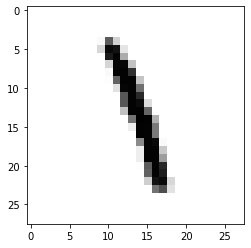

In [72]:
plt.imshow(X_test[test_index].reshape(28,28),cmap='Greys',interpolation='nearest')
plt.show()

## HVPs+Lissa

In [0]:
def get_inverse_hvp_lissa(sess, v, X, Y, v_cur_est, hessian_vector_val, batch_size=None, 
                          scale=10, damping=0.0, num_samples=1, recursion_depth=10000):
    """
    This uses mini-batching; uncomment code for the single sample case.
    """    
    inverse_hvp = None
    print_iter = recursion_depth / 10
    start_time = time.time()
    r=np.random.randint(len(X_train), size=[num_samples])
    batch_xs = X[r]
    batch_ys = Y[r]
    prev_norm=10
    for i in range(num_samples):
        cur_estimate = v
        for j in range(recursion_depth):
            feed_dict = {place:cur for place, cur in zip(v_cur_est, cur_estimate)}
            hvp = sess.run(hessian_vector_val, feed_dict={X:batch_xs[i:i+1], Y:batch_ys[i:i+1], **feed_dict})
            cur_estimate = [a + (1-damping/scale) * b - c/scale for (a,b,c) in zip(v, cur_estimate, hvp)]    

        if (i %  int(num_samples/10) == 0) or (i==num_samples-1):
            cur_norm = np.linalg.norm(np.concatenate(cur_estimate))
            print("Recursion at depth %s: norm is %.8lf" % (j, cur_norm))

        if inverse_hvp is None:
            inverse_hvp = [b/scale for b in cur_estimate]
        else:
            inverse_hvp = [a + b/scale for (a, b) in zip(inverse_hvp, cur_estimate)]  

    inverse_hvp = [a/num_samples for a in inverse_hvp]
    duration = time.time() - start_time
    print('Inverse HVP by HVPs+Lissa: took %s minute %s sec' % (duration//60, duration%60))   
    return inverse_hvp

In [74]:
inverse_hvp = get_inverse_hvp_lissa(sess, test_val, X_train, Y_train, v_cur_est, hessian_vector_val, scale=10000,  damping=0.00, num_samples=512, recursion_depth=50)

Recursion at depth 49: norm is 0.77773404
Recursion at depth 49: norm is 0.77709579
Recursion at depth 49: norm is 0.77774602
Recursion at depth 49: norm is 0.77731210
Recursion at depth 49: norm is 0.77774584
Recursion at depth 49: norm is 0.77760029
Recursion at depth 49: norm is 0.76627398
Recursion at depth 49: norm is 0.77774358
Recursion at depth 49: norm is 0.77774543
Recursion at depth 49: norm is 0.77772480
Recursion at depth 49: norm is 0.77772760
Recursion at depth 49: norm is 0.77774465
Inverse HVP by HVPs+Lissa: took 3.0 minute 33.35926842689514 sec


In [75]:
inverse_hvp[3]

array([ 9.5727393e-10,  2.1417915e-07, -1.9601590e-08, ...,
       -2.4708539e-08, -1.0329779e-07, -7.6295680e-07], dtype=float32)

## by hvp

In [101]:
one_class = True

if one_class == True:
    s=time.time()
    val_lissa=[]
    for i in range(len(X_train)):
        if np.argmax(Y_train[i])==np.argmax(Y_test[test_index]):
            z_train=X_train[i].reshape((1,28,28,1))
            z_train_label=Y_train[i].reshape((1,10))
            train_grad_loss_val=sess.run(grad, feed_dict={X:z_train, Y:z_train_label})
            val_lissa.append([i, np.dot(np.concatenate(inverse_hvp), np.concatenate(train_grad_loss_val))])
    duration = time.time() - s
    print('Multiplying by %s train examples took %s minute %s sec' % (1, duration//60, duration%60))
    val_lissa=sorted(val_lissa, key=lambda x: x[1])[::-1]
else:
    s=time.time()
    val_lissa=[]
    for i in range(len(X_train)):
        z_train=X_train[i].reshape((1,28,28,1))
        z_train_label=Y_train[i].reshape((1,10))
        train_grad_loss_val=sess.run(grad, feed_dict={X:z_train, Y:z_train_label})
        val_lissa.append([i, np.dot(np.concatenate(inverse_hvp), np.concatenate(train_grad_loss_val))])
    duration = time.time() - s
    print('Multiplying by %s train examples took %s minute %s sec' % (1, duration//60, duration%60))
    val_lissa=sorted(val_lissa, key=lambda x: x[1])[::-1]

Multiplying by 1 train examples took 0.0 minute 29.064437866210938 sec


#  Pictures

In [102]:
print(val_lissa[0][0], val_lissa[1][0], val_lissa[2][0], val_lissa[3][0], val_lissa[4][0], val_lissa[5][0])
print(val_lissa[-1][0], val_lissa[-2][0], val_lissa[-3][0], val_lissa[-4][0], val_lissa[-5][0], val_lissa[-6][0])
val=val_lissa

38700 47291 31727 37038 47022 37816
5859 11765 20319 57243 40651 57453


In [103]:
val[:5]

[[38700, 0.0023798887],
 [47291, 0.0023389691],
 [31727, 0.002016752],
 [37038, 0.0019895479],
 [47022, 0.001983365]]

In [104]:
val[-5:]

[[40651, -2.8198838e-07],
 [57243, -2.8203863e-07],
 [20319, -2.8209394e-07],
 [11765, -2.8215078e-07],
 [5859, -2.8222945e-07]]

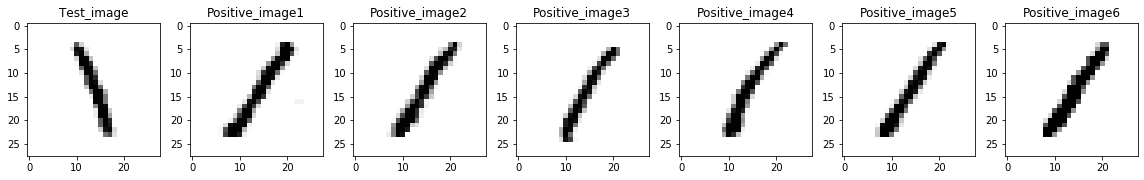

In [105]:
fig = plt.figure(figsize=(16, 4))
for i in range(1, 8):
    ax = plt.subplot(1, 7, i)
    if i == 1:
        plt.imshow(X_test[test_index].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Test_image')
    elif i == 2:
        plt.imshow(X_train[val[-1][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image1')
    elif i == 3:
        plt.imshow(X_train[val[-2][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image2')
    elif i == 4:
        plt.imshow(X_train[val[-3][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image3')
    elif i == 5:
        plt.imshow(X_train[val[-4][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image4')
    elif i == 6:
        plt.imshow(X_train[val[-5][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image5')
    elif i == 7:
        plt.imshow(X_train[val[-6][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image6')
plt.tight_layout()
plt.show()

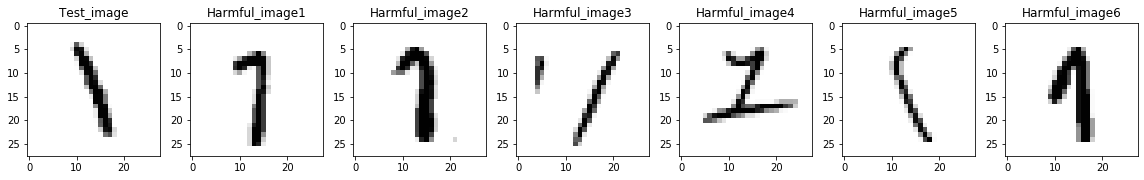

In [106]:
fig = plt.figure(figsize=(16, 4))
for i in range(1, 8):
    ax = plt.subplot(1, 7, i)
    if i == 1:
        plt.imshow(X_test[test_index].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Test_image')
    elif i == 2:
        plt.imshow(X_train[val[0][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image1')
    elif i == 3:
        plt.imshow(X_train[val[1][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image2')
    elif i == 4:
        plt.imshow(X_train[val[2][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image3')
    elif i == 5:
        plt.imshow(X_train[val[3][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image4')
    elif i == 6:
        plt.imshow(X_train[val[4][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image5')
    elif i == 7:
        plt.imshow(X_train[val[5][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image6')
plt.tight_layout()
plt.show()